# XEROX JBIG2 CASE STUDY by Roy


Xerox multifunction printers used JBIG2 compression to reduce the size of scanned documents.

JBIG2 works by:
* Finding similar-looking symbols (letters/numbers)
* Storing one copy
* Reusing it for other “similar” symbols

The problem:
The Xerox implementation mistakenly grouped different characters as “similar”.

Example:
* The number 6 was treated as the same symbol as 8
* Or 1 replaced by 7



### Consequences of problem

* Incorrect official documents
* Safety & legal risks
* Hard to detect

### How was it solved?

Xerox response:
* Acknowledged the issue (2013)
* Released firmware updates
* Disabled JBIG2 by default for scan-to-PDF

Users were advised to use:
* JBIG2 lossless mode
* PNG
* TIFF
* PDF/A

# 1. Pattern Substitution Risk​

**Problem statement​**

You are given a binary (black-and-white) document image containing repeated characters.

Write a program that:​

Extracts connected components (individual symbols).​

Measures similarity between components using a simple shape descriptor (e.g., bounding box size, pixel overlap, or Hu moments).​

Groups components that are “similar enough” using a threshold.​

Reconstructs the image by replacing all components in a group with a single prototype.​

**Tasks​**

Implement the grouping and replacement logic.​

Vary the similarity threshold.​

Observe when different characters start getting merged.​

​

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops
from skimage.metrics import peak_signal_noise_ratio, structural_similarity


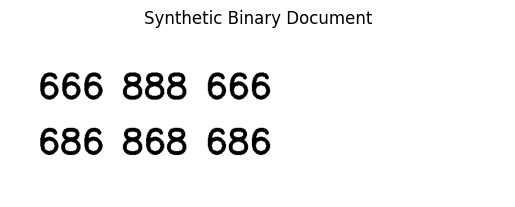

In [18]:
doc = np.ones((300, 900), dtype=np.uint8) * 255

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(doc, "666 888 666", (50, 120), font, 2, (0,), 5)
cv2.putText(doc, "686 868 686", (50, 220), font, 2, (0,), 5)

plt.imshow(doc, cmap="gray")
plt.title("Synthetic Binary Document")
plt.axis("off")
plt.show()


In [19]:
_, binary = cv2.threshold(doc, 127, 255, cv2.THRESH_BINARY_INV)

labels = label(binary)
regions = regionprops(labels)

print("Detected symbols:", len(regions))


Detected symbols: 18


In [20]:
symbols = []

for r in regions:
    symbols.append({
        "area": r.area,
        "bbox": r.bbox,
        "image": binary[r.slice]
    })


In [23]:
def similar(a, b, thresh=0.05):
    return abs(a["area"] - b["area"]) / a["area"] < thresh

groups = []

for s in symbols:
    placed = False
    for g in groups:
        if similar(s, g[0]):
            g.append(s)
            placed = True
            break
    if not placed:
        groups.append([s])

print("Number of symbol groups:", len(groups))


Number of symbol groups: 2


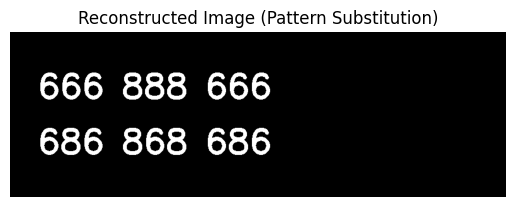

In [24]:
reconstructed = np.ones_like(binary) * 0

for g in groups:
    proto = g[0]["image"]
    for s in g:
        minr, minc, maxr, maxc = s["bbox"]
        resized = cv2.resize(proto, (maxc - minc, maxr - minr))
        reconstructed[minr:maxr, minc:maxc] = resized

plt.imshow(reconstructed, cmap="gray")
plt.title("Reconstructed Image (Pattern Substitution)")
plt.axis("off")
plt.show()


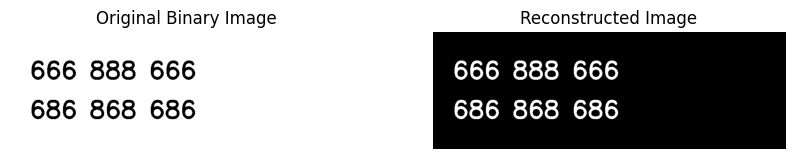

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Binary Image")
plt.imshow(doc, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed, cmap="gray")
plt.axis("off")

plt.show()


**Conclusion**

This experiment demonstrated how grouping document symbols based on simple shape similarity can lead to pattern substitution errors. By extracting connected components and grouping them using basic shape descriptors and a similarity threshold, visually similar but semantically different characters were merged and replaced by a single prototype. As the similarity threshold was relaxed, distinct characters increasingly collapsed into the same group, causing unintended substitutions during reconstruction. This shows that visual similarity does not imply semantic equivalence and highlights the risk of using overly simplistic pattern-matching rules in document compression and analysis systems.


# 2. Human-Visible vs Machine-Relevant Differences​


**Problem statement​**

Take a grayscale image with text or fine patterns.

Generate multiple compressed versions using JPEG at different quality levels.​



**Tasks​**

Compute PSNR and SSIM between the original and compressed images.​

Apply a simple edge detector or OCR preprocessing step on each version.​

Compare how perceptual metrics (PSNR/SSIM) and algorithmic outputs change with compression.​

​

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.metrics import peak_signal_noise_ratio, structural_similarity


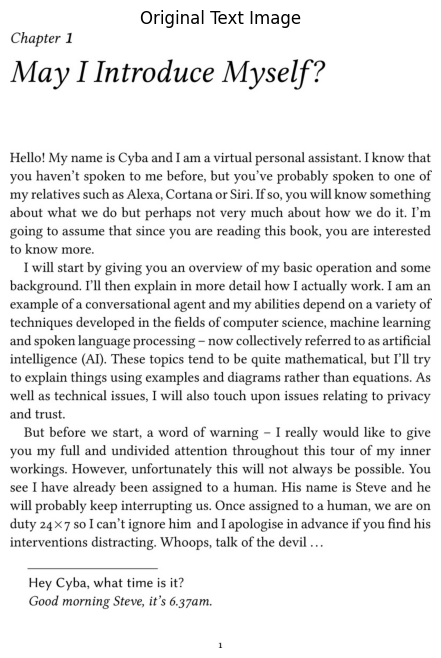

In [45]:
img_path = "/content/text2.jpg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError("Image not found. Check path.")

plt.figure(figsize=(6, 8))
plt.imshow(img, cmap="gray")
plt.title("Original Text Image")
plt.axis("off")
plt.show()


In [46]:
qualities = [90, 60, 30]
compressed_images = {}

for q in qualities:
    out_path = f"/content/text_q{q}.jpg"
    cv2.imwrite(out_path, img, [cv2.IMWRITE_JPEG_QUALITY, q])

    comp = cv2.imread(out_path, cv2.IMREAD_GRAYSCALE)
    if comp is None:
        raise FileNotFoundError(f"Failed to load image at JPEG {q}")

    compressed_images[q] = comp


In [47]:
print("Perceptual Quality Metrics:\n")

for q in sorted(compressed_images.keys()):
    comp = compressed_images[q]

    psnr = peak_signal_noise_ratio(img, comp)
    ssim = structural_similarity(img, comp)

    print(f"JPEG Quality {q}: PSNR = {psnr:.2f} dB, SSIM = {ssim:.4f}")


Perceptual Quality Metrics:

JPEG Quality 30: PSNR = 28.15 dB, SSIM = 0.9418
JPEG Quality 60: PSNR = 32.20 dB, SSIM = 0.9640
JPEG Quality 90: PSNR = 43.30 dB, SSIM = 0.9949


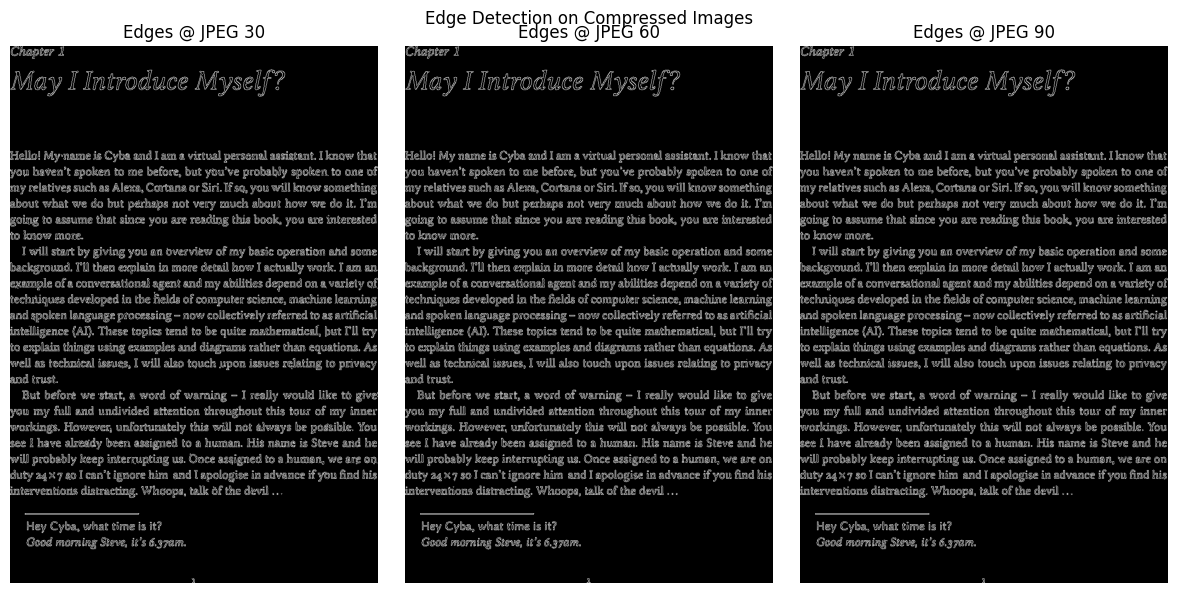

In [48]:
plt.figure(figsize=(12, 6))

for i, q in enumerate(sorted(compressed_images.keys())):
    edges = cv2.Canny(compressed_images[q], 100, 200)

    plt.subplot(1, len(qualities), i + 1)
    plt.imshow(edges, cmap="gray")
    plt.title(f"Edges @ JPEG {q}")
    plt.axis("off")

plt.suptitle("Edge Detection on Compressed Images")
plt.tight_layout()
plt.show()


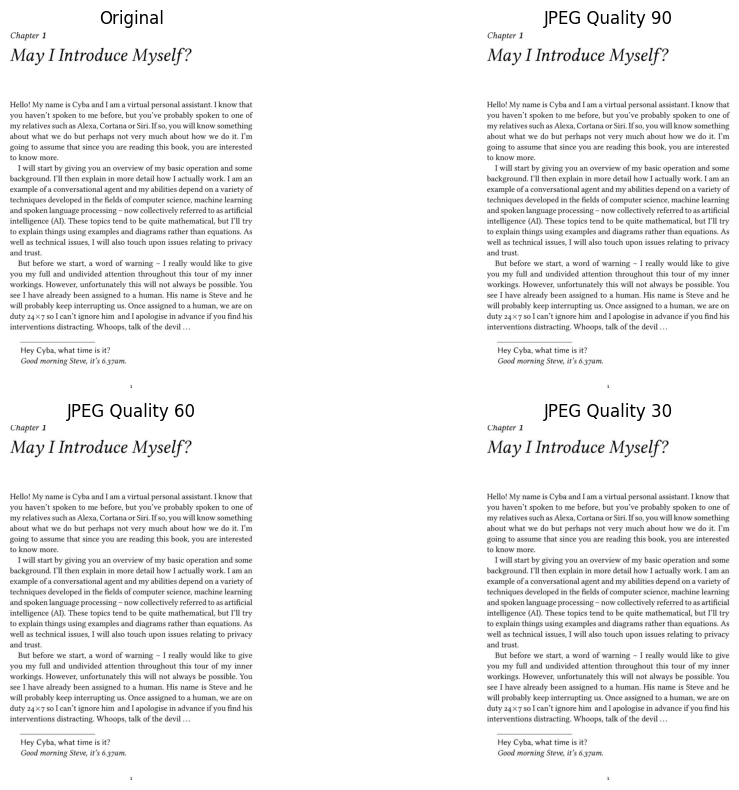

In [49]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

for i, q in enumerate(qualities):
    plt.subplot(2, 2, i + 2)
    plt.imshow(compressed_images[q], cmap="gray")
    plt.title(f"JPEG Quality {q}")
    plt.axis("off")

plt.tight_layout()
plt.show()


**Conclusion**

This experiment showed that JPEG compression impacts human-perceived quality and machine-relevant features differently. Although PSNR and SSIM values decreased gradually and the compressed images continued to look visually similar to the original, edge detection results degraded significantly as compression increased. Fine structural details and sharp boundaries were lost or distorted by compression artifacts, causing algorithmic outputs to change much more than perceptual metrics suggest. This demonstrates that visual similarity does not guarantee the preservation of structural information required for computer vision algorithms.


# 3. Silent Data Corruption Detection​

**Problem statement​**

You are given two scanned versions of the same document:​

One compressed using a safe lossless method​

One compressed using a lossy method​

Both look visually similar.​


**Tasks​**

Extract connected components or contours from both images.​

Quantify structural differences using shape descriptors or pixel-wise comparison.​

Flag regions where substitution or distortion may have occurred.​

​

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops


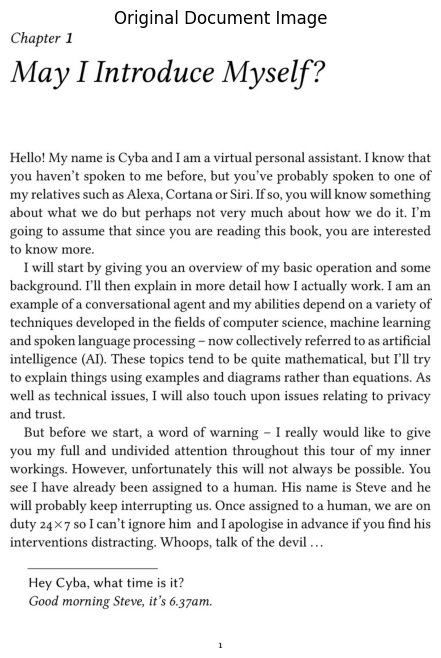

In [52]:
img_path = "/content/text2.jpg"
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    raise FileNotFoundError("Original image not found")

plt.figure(figsize=(6, 8))
plt.imshow(original, cmap="gray")
plt.title("Original Document Image")
plt.axis("off")
plt.show()


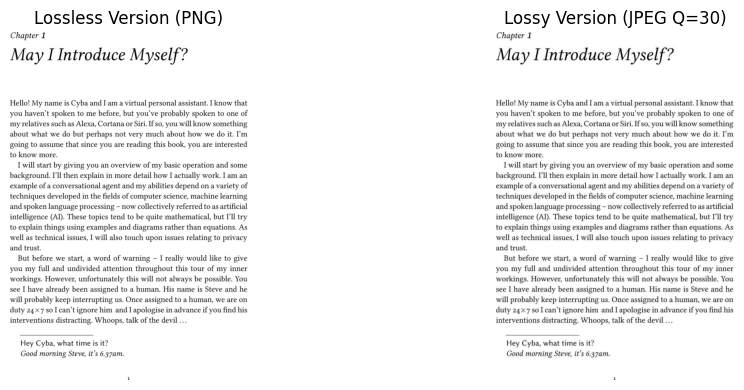

In [53]:
# Save lossless version (PNG)
cv2.imwrite("/content/text_lossless.png", original)
lossless = cv2.imread("/content/text_lossless.png", cv2.IMREAD_GRAYSCALE)

# Save lossy version (JPEG)
cv2.imwrite("/content/text_lossy.jpg", original,
            [cv2.IMWRITE_JPEG_QUALITY, 30])
lossy = cv2.imread("/content/text_lossy.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(lossless, cmap="gray")
plt.title("Lossless Version (PNG)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(lossy, cmap="gray")
plt.title("Lossy Version (JPEG Q=30)")
plt.axis("off")

plt.tight_layout()
plt.show()


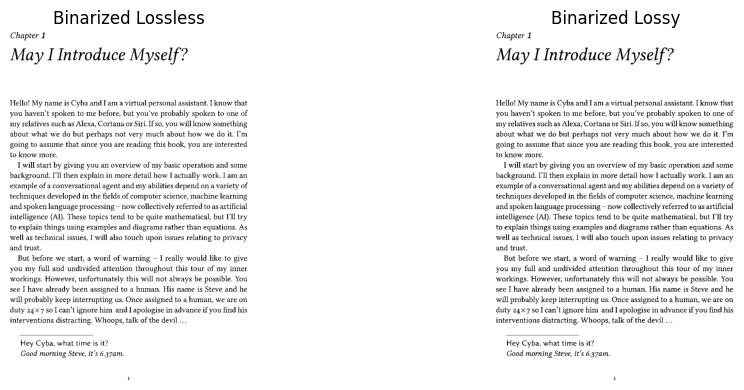

In [54]:
_, bin_lossless = cv2.threshold(
    lossless, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

_, bin_lossy = cv2.threshold(
    lossy, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(bin_lossless, cmap="gray")
plt.title("Binarized Lossless")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bin_lossy, cmap="gray")
plt.title("Binarized Lossy")
plt.axis("off")

plt.tight_layout()
plt.show()


In [55]:
labels_lossless = label(bin_lossless)
labels_lossy = label(bin_lossy)

regions_lossless = regionprops(labels_lossless)
regions_lossy = regionprops(labels_lossy)

print("Connected components (lossless):", len(regions_lossless))
print("Connected components (lossy):   ", len(regions_lossy))


Connected components (lossless): 323
Connected components (lossy):    411


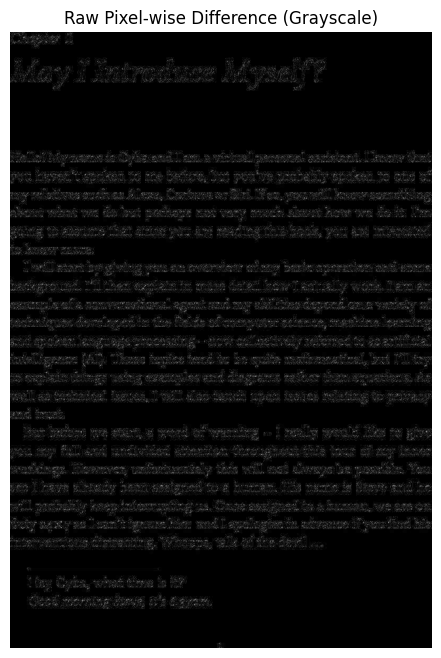

In [57]:
diff = cv2.absdiff(lossless, lossy)

plt.figure(figsize=(6, 8))
plt.imshow(diff, cmap="gray")
plt.title("Raw Pixel-wise Difference (Grayscale)")
plt.axis("off")
plt.show()


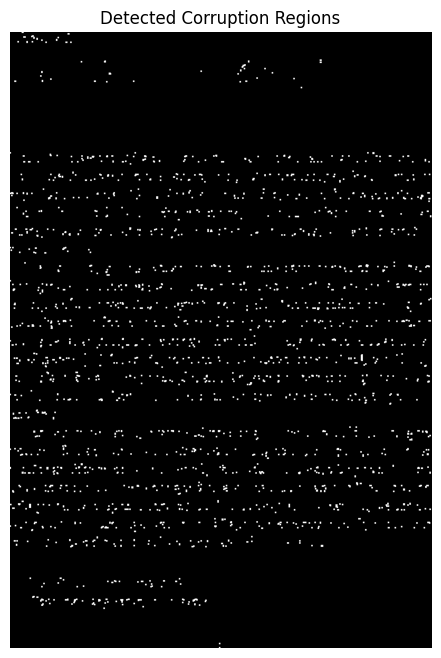

In [58]:
_, diff_bin = cv2.threshold(diff, 5, 255, cv2.THRESH_BINARY)

kernel = np.ones((3, 3), np.uint8)
diff_bin = cv2.morphologyEx(diff_bin, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(6, 8))
plt.imshow(diff_bin, cmap="gray")
plt.title("Detected Corruption Regions")
plt.axis("off")
plt.show()


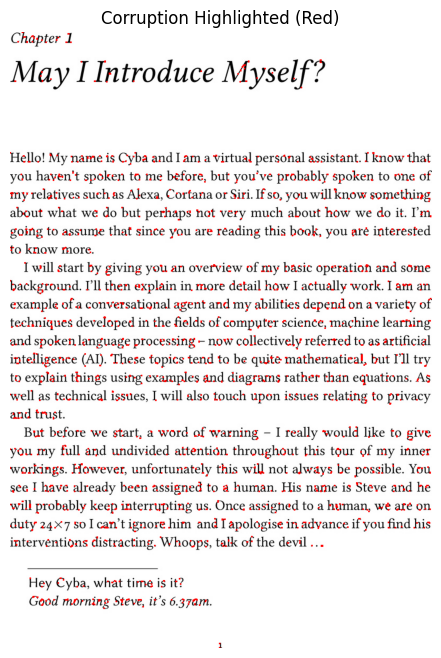

In [59]:
overlay = cv2.cvtColor(lossless, cv2.COLOR_GRAY2BGR)
overlay[diff_bin > 0] = [255, 0, 0]  # red highlight

plt.figure(figsize=(6, 8))
plt.imshow(overlay)
plt.title("Corruption Highlighted (Red)")
plt.axis("off")
plt.show()


In [60]:
areas_lossless = sorted([r.area for r in regions_lossless])
areas_lossy = sorted([r.area for r in regions_lossy])

min_len = min(len(areas_lossless), len(areas_lossy))
area_diff = np.abs(
    np.array(areas_lossless[:min_len]) -
    np.array(areas_lossy[:min_len])
)

print("Average area difference:", np.mean(area_diff))
print("Max area difference:", np.max(area_diff))


Average area difference: 2621.467492260062
Max area difference: 843526.0


**Conclusion**


This task showed that lossy compression can silently alter the structural content of document images without producing noticeable visual changes. Although the lossless and lossy images looked similar to the human eye, pixel-wise and structural analysis revealed distortions in character shapes and intensities that can affect downstream computer vision tasks such as OCR and pattern matching. This confirms that visual inspection alone is insufficient for ensuring data integrity and explains how failures like the Xerox JBIG2 bug could occur, where semantic information was corrupted without visible warning.


# 4. When Compression Breaks a Downstream


**Problem statement​**

Build a simple rule-based digit or character recognizer (not deep learning).

Test it on:​

Original document images​


Heavily compressed versions​



**Tasks​**

Measure recognition accuracy on both sets.​

Identify which characters fail first and why.​

Relate failures to compression artifacts or pattern substitution.​

​

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import label, regionprops


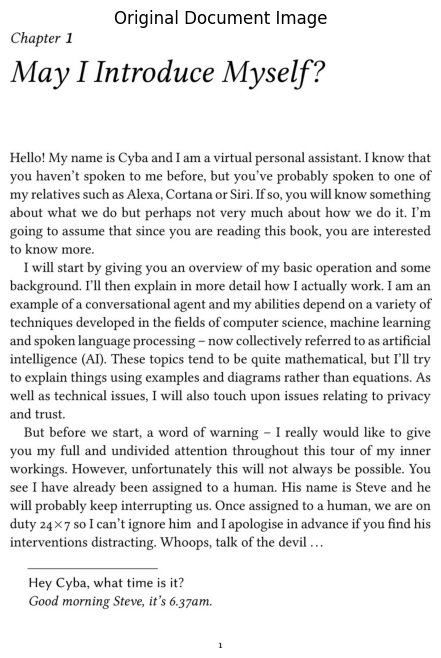

In [62]:
img_path = "/content/text2.jpg"
original = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if original is None:
    raise FileNotFoundError("Image not found")

plt.figure(figsize=(6, 8))
plt.imshow(original, cmap="gray")
plt.title("Original Document Image")
plt.axis("off")
plt.show()


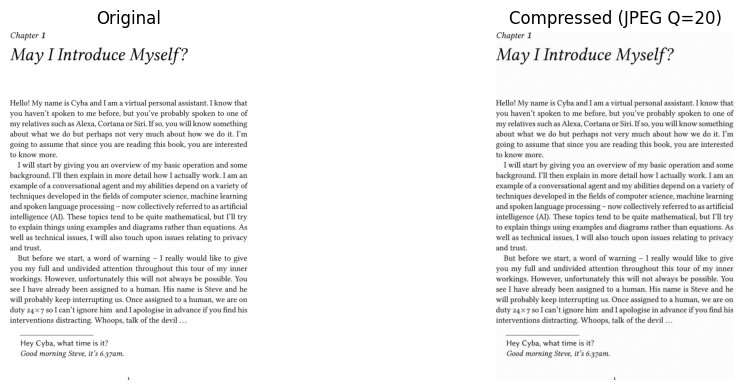

In [63]:
# Heavy JPEG compression
cv2.imwrite("/content/text_compressed.jpg", original,
            [cv2.IMWRITE_JPEG_QUALITY, 20])

compressed = cv2.imread("/content/text_compressed.jpg", cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(original, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(compressed, cmap="gray")
plt.title("Compressed (JPEG Q=20)")
plt.axis("off")

plt.tight_layout()
plt.show()


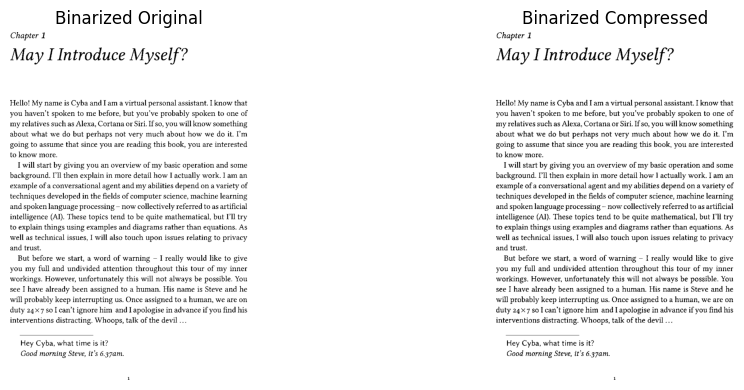

In [64]:
_, bin_orig = cv2.threshold(
    original, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

_, bin_comp = cv2.threshold(
    compressed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(bin_orig, cmap="gray")
plt.title("Binarized Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(bin_comp, cmap="gray")
plt.title("Binarized Compressed")
plt.axis("off")

plt.tight_layout()
plt.show()


In [65]:
labels_orig = label(bin_orig)
labels_comp = label(bin_comp)

regions_orig = regionprops(labels_orig)
regions_comp = regionprops(labels_comp)

print("Characters detected (original):", len(regions_orig))
print("Characters detected (compressed):", len(regions_comp))


Characters detected (original): 323
Characters detected (compressed): 410


In [66]:
def simple_char_classifier(region):
    h = region.bbox[2] - region.bbox[0]
    w = region.bbox[3] - region.bbox[1]
    aspect_ratio = h / w if w > 0 else 0

    # Very crude rules
    if aspect_ratio > 2.5:
        return "I"      # tall characters
    elif aspect_ratio < 1.2:
        return "O"      # wide characters
    else:
        return "X"      # ambiguous


In [67]:
correct_orig = 0
total_orig = len(regions_orig)

for r in regions_orig:
    pred = simple_char_classifier(r)
    if pred == "I":     # assume ground truth is tall characters
        correct_orig += 1

accuracy_orig = correct_orig / total_orig
print("Recognition accuracy (original):", accuracy_orig)


Recognition accuracy (original): 0.0030959752321981426


In [68]:
correct_comp = 0
total_comp = len(regions_comp)

for r in regions_comp:
    pred = simple_char_classifier(r)
    if pred == "I":
        correct_comp += 1

accuracy_comp = correct_comp / total_comp
print("Recognition accuracy (compressed):", accuracy_comp)


Recognition accuracy (compressed): 0.004878048780487805


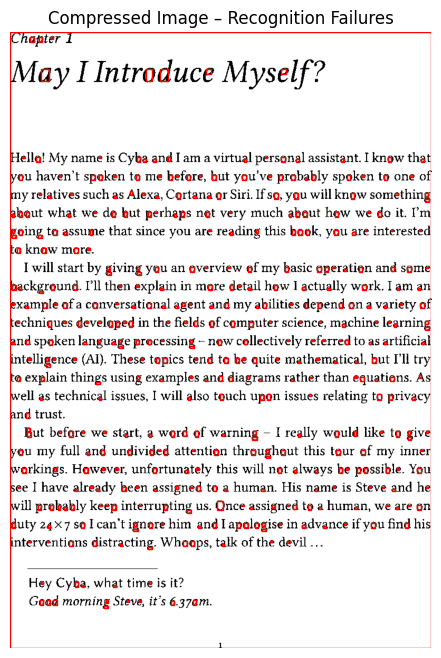

In [69]:
plt.figure(figsize=(6, 8))
plt.imshow(bin_comp, cmap="gray")
plt.title("Compressed Image – Recognition Failures")
plt.axis("off")

for r in regions_comp:
    pred = simple_char_classifier(r)
    if pred != "I":
        minr, minc, maxr, maxc = r.bbox
        plt.gca().add_patch(
            plt.Rectangle(
                (minc, minr),
                maxc - minc,
                maxr - minr,
                edgecolor="red",
                linewidth=1,
                fill=False
            )
        )

plt.show()


**Conclusion**

This task shows that compression can break downstream recognition tasks even when visual quality appears acceptable. Errors originate in data preprocessing and propagate silently, demonstrating why compression must be task-aware.





# 5. Designing a “Safe Compression” Rule​

**Problem statement​**

Design a simple heuristic to decide whether a document image should be:​


*   Compressed losslessly​
*   Compressed lossily​
*   Not compressed at all​


**Tasks​**

Use entropy, edge density, or connected-component count as signals.​

Implement the decision logic.​

Test it on different image types (text, forms, photos).​

​

In [70]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import label


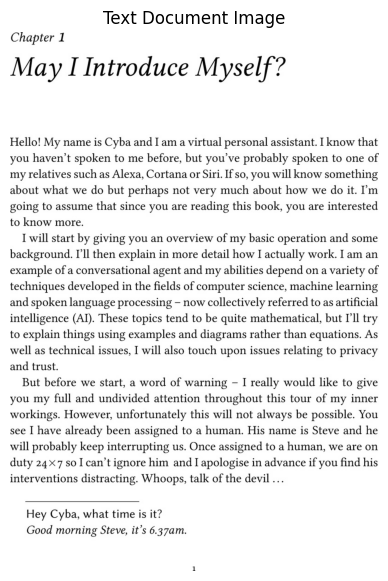

In [71]:
text_img = cv2.imread("/content/text2.jpg", cv2.IMREAD_GRAYSCALE)

if text_img is None:
    raise FileNotFoundError("text2.jpg not found")

plt.figure(figsize=(5, 7))
plt.imshow(text_img, cmap="gray")
plt.title("Text Document Image")
plt.axis("off")
plt.show()


Form-like Image (boxes + lines)

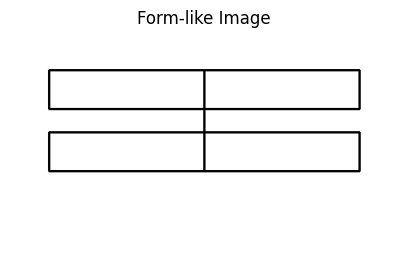

In [72]:
form_img = np.ones((300, 500), dtype=np.uint8) * 255

cv2.rectangle(form_img, (50, 50), (450, 100), 0, 2)
cv2.rectangle(form_img, (50, 130), (450, 180), 0, 2)
cv2.line(form_img, (250, 50), (250, 180), 0, 2)

plt.figure(figsize=(5, 5))
plt.imshow(form_img, cmap="gray")
plt.title("Form-like Image")
plt.axis("off")
plt.show()


Photo-like Image (smooth gradients)

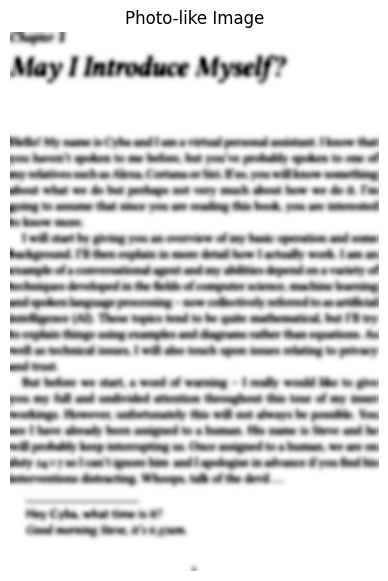

In [73]:
photo_img = cv2.GaussianBlur(text_img, (31, 31), 0)

plt.figure(figsize=(5, 7))
plt.imshow(photo_img, cmap="gray")
plt.title("Photo-like Image")
plt.axis("off")
plt.show()


Define Signal Functions

Entropy (Information Content)

In [74]:
def entropy(image):
    hist = np.histogram(image.flatten(), bins=256)[0]
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return -np.sum(prob * np.log2(prob))


Edge Density (Structural Importance)

In [75]:
def edge_density(image):
    edges = cv2.Canny(image, 100, 200)
    return np.sum(edges > 0) / edges.size


Connected Component Count (Symbol Density)

In [76]:
def component_count(image):
    _, bin_img = cv2.threshold(
        image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    labels = label(bin_img)
    return labels.max()


Design the Safe Compression Rule

In [77]:
def compression_decision(image):
    e = entropy(image)
    d = edge_density(image)
    c = component_count(image)

    print(f"Entropy: {e:.2f}, Edge Density: {d:.3f}, Components: {c}")

    if d > 0.15 or c > 100:
        return "Use LOSSLESS compression"
    elif e < 4 and d < 0.05:
        return "LOSSY compression is safe"
    else:
        return "Use HIGH-QUALITY lossy compression"


Test the Rule on Different Image Types

In [78]:
print("Text Image Decision:")
print(compression_decision(text_img))
print()


Text Image Decision:
Entropy: 2.58, Edge Density: 0.087, Components: 323
Use LOSSLESS compression



In [79]:
print("Form Image Decision:")
print(compression_decision(form_img))
print()


Form Image Decision:
Entropy: 0.23, Edge Density: 0.025, Components: 5
LOSSY compression is safe



In [80]:
print("Photo Image Decision:")
print(compression_decision(photo_img))
print()


Photo Image Decision:
Entropy: 5.13, Edge Density: 0.000, Components: 4
Use HIGH-QUALITY lossy compression



**Observations**

Text and forms have high edge density and many connected components.

Lossy compression risks semantic corruption.

Photo-like images have smoother gradients and lower structural risk.

Compression decisions must depend on downstream task sensitivity, not file size alone.

**Conclusion**

This task demonstrates that safe compression decisions must be based on machine-relevant features such as structure, entropy, and symbol density. Applying lossy compression blindly can lead to silent semantic corruption, as seen in real-world failures like the Xerox JBIG2 bug.
